In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


In [10]:
train_dataset = datasets.ImageFolder("data/train", transform=train_transforms)
test_dataset  = datasets.ImageFolder("data/test", transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_dataset.classes)  # ['Cat', 'Dog']


['Cat', 'Dog']


In [11]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [12]:
model = CatDogCNN().to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {running_loss:.4f} "
          f"Train Acc: {train_acc:.2f}%")


Epoch [1/5] Loss: 181.0955 Train Acc: 87.66%
Epoch [2/5] Loss: 163.4145 Train Acc: 88.83%
Epoch [3/5] Loss: 148.5218 Train Acc: 89.98%
Epoch [4/5] Loss: 134.2229 Train Acc: 91.23%
Epoch [5/5] Loss: 124.8328 Train Acc: 91.91%


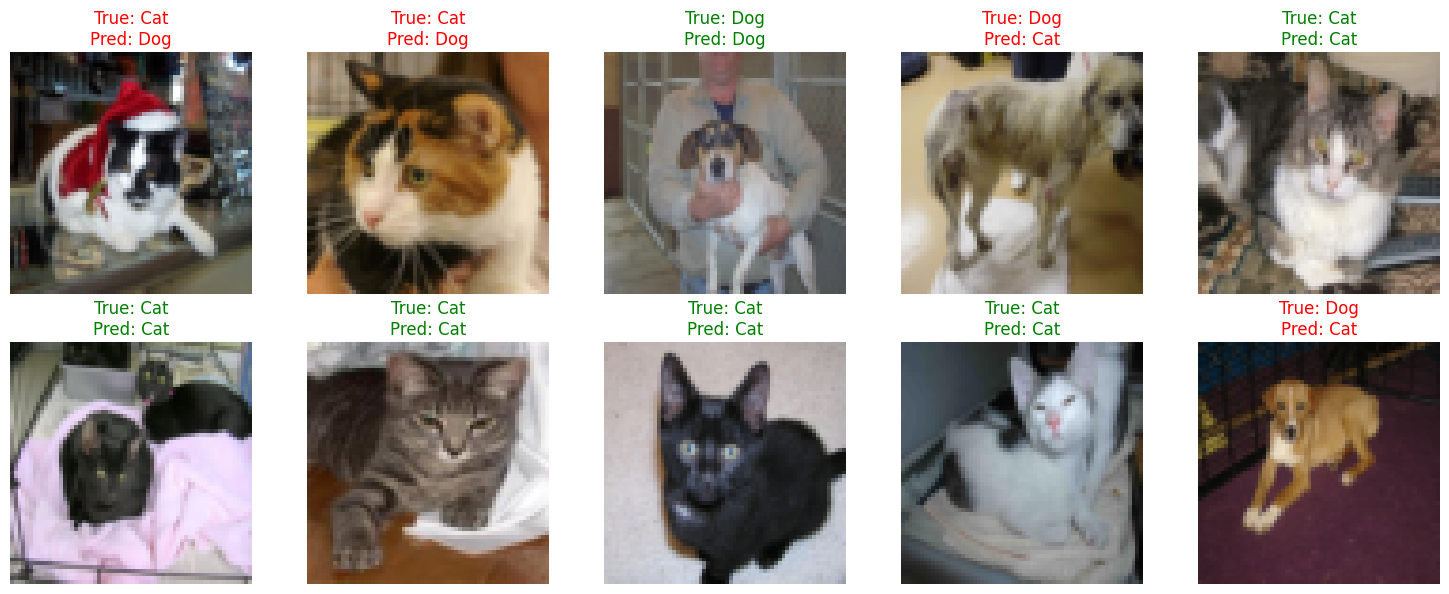

In [26]:
import random

import matplotlib.pyplot as plt

# Get 10 random samples from test dataset
num_samples = 10
indices = random.sample(range(len(test_dataset)), num_samples)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

model.eval()
with torch.no_grad():
    for idx, test_idx in enumerate(indices):
        image, true_label = test_dataset[test_idx]
        
        # Get prediction
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        _, pred_label = torch.max(output, 1)
        
        # Denormalize image for display
        img_display = image.permute(1, 2, 0).cpu().numpy()
        img_display = img_display * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
        img_display = img_display.clip(0, 1)
        
        # Get class names
        true_class = train_dataset.classes[true_label]
        pred_class = train_dataset.classes[pred_label.item()]
        
        # Plot
        axes[idx].imshow(img_display)
        axes[idx].axis('off')
        color = 'green' if true_label == pred_label.item() else 'red'
        axes[idx].set_title(f'True: {true_class}\nPred: {pred_class}', color=color)

plt.tight_layout()
plt.show()

In [27]:
# Save the model
torch.save(model.state_dict(), "cat_dog_cnn.pth")